In [1]:
import os
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
sys.path
import data_loader as dl

The purpose of this function is to clean up the original 'before' data so that we are not counting decoys or duplicate scans. Mokapot needs the decoys, so they are only removed from the 'before' data.

In [2]:
def filter_data(df, cutoff, prob_column='PEP'):
    #drop decoys
    df = df[df["decoy"]==False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #drop duplicate scans
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring

    return df

MokaPot needs a column that notates whether a scan was decoy or not. The "make_decoy_col_maxquant" function generates that column.

In [3]:
def make_decoy_col_maxquant(row):
    if row["Reverse"].startswith("+"):
        return False
    else:
        return True

Here we read in the data and clean it up before we run it thorugh MokaPot. 
We drop any duplicate scans before the data is fed into MokaPot. We also change the scan number name so that all of our files will match in the end so we can merge them into one megascript. 

In [4]:
#Reading in the data and formatting it for MokaPot
def get_data_for_MokaPot(filename):
    mq_df =  dl.clean_maxquant(filename)
    mq_df["target_column"] = mq_df.apply(make_decoy_col_maxquant, axis = 1)
    
    
    #Dropping any rows that are missing the sequence
    mq_df['Sequence'].replace(' ', np.nan, inplace = True)
    mq_df.dropna(subset=['Sequence'], inplace=True)
    
    #sort and drop duplicate scans
    mq_df = mq_df.sort_values('PEP')
    mq_df = mq_df.drop_duplicates(subset=["scan"], keep="first") #keep highest coring
    
    
    mq_df = mq_df.rename(columns = {"scan": "ScanNr"})
    
    return mq_df

This gives us back a dataset that drops the decoys, duplicate scans, and rows without a sequence number. It has not been ran through MokaPot. The purpose of this is to be able to count how many scans we originally have at or under a specific cutoff. 

In [5]:
def get_PreMokaPot_data(filename):
    mq_df =  dl.clean_maxquant(filename)
    
#Formatting and dropping any rows that are missing the sequence (Do we still want this??)
    mq_df['Sequence'].replace(' ', np.nan, inplace = True)
    mq_df.dropna(subset=['Sequence'], inplace=True)
    
    mq_df = filter_data(mq_df, 0.01)
    
    return  mq_df


This is code that was taken from the MokaPot program. It formats the data for the graphs. THe purpose of the graphs is to compare the preMokaPot data to the postMokaPot data and compare if we are getting more scans at or below a certain cutoff after running data through MokaPot. 
MaxQuant does not have a q value, so instead we are using the PEP. 

In [6]:
def plot_qvalues(df, level="psms", threshold=0.01, ax=None, **kwargs):
    qvals = df["PEP"]

    ax = plot_qvalues(qvals, threshold=threshold, ax=ax, **kwargs)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Accepted {self._level_labs[level]}")

    return ax

In [7]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [8]:
#all the files we want to run through MokaPot here 
file_names = ["2ng_rep1", "2ng_rep2", "2ng_rep3", "2ng_rep4", "2ng_rep5", "2ng_rep6",
             "0.2ng_rep1", "0.2ng_rep2", "0.2ng_rep3", "0.2ng_rep4", "0.2ng_rep5", "0.2ng_rep6"]

This is where we run each input file through MokaPot. Each file we read in is analyzed and the results are saved in a seperate output file.

MokaPot requires feature columns that it uses to give each scan a new q value score. The columns from MaxQuant that we have chosen to use as features are: 'Precursor Intensity', 'Score','Length', 'Missed cleavages', 'm/z', 'Mass', 'Retention time', and 'Delta score'. 'Charge' is also used as an one hot encoding per the recommendation of the writer of MokaPot. 

In [14]:
for file in file_names:
    mq_cleaned_df = get_PreMokaPot_data(file)
    mq_df = get_data_for_MokaPot(file)

    charge_feat = pd.get_dummies(mq_df["Charge"], prefix="Charge")
    mq_df = pd.concat([mq_df, charge_feat], axis=1)

    mq_for_MP = mokapot.dataset.LinearPsmDataset(mq_df, target_column = "target_column", spectrum_columns = "ScanNr", 
                                                     peptide_column = "peptide", protein_column=None, 
                                                     group_column=None, feature_columns=(list(charge_feat.columns) + ["Precursor Intensity", 'Score', 
                                                                                                                      'Length', 'Missed cleavages', 'm/z', 'Mass', 
                                                                                                                      'Retention time', 'Delta score', ]), copy_data=True)
    results, models = mokapot.brew(mq_for_MP)

    results_df = results.psms
    results_df.to_csv("MokaPot_Output/MaxQuant/mq_" + file + ".csv")
    
    print("\n" + "The number of PSMs found at or above 0.01 for file " + file + ":")   
    print("\t" + "MaxQuant: " + str(len(mq_cleaned_df[mq_cleaned_df['PEP'] <= 0.01])))
    print("\t""MaxQuant and MokaPot: " + str(len(results.psms[results.psms['mokapot q-value'] <= 0.01]))) 

../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 2ng_rep1:
	MaxQuant: 7900
	MaxQuant and MokaPot: 11720


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 2ng_rep2:
	MaxQuant: 8210
	MaxQuant and MokaPot: 11101


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 2ng_rep3:
	MaxQuant: 6067
	MaxQuant and MokaPot: 9407


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 2ng_rep4:
	MaxQuant: 6401
	MaxQuant and MokaPot: 9052


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 2ng_rep5:
	MaxQuant: 11196
	MaxQuant and MokaPot: 14040


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 2ng_rep6:
	MaxQuant: 10361
	MaxQuant and MokaPot: 13151


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 0.2ng_rep1:
	MaxQuant: 4096
	MaxQuant and MokaPot: 6012


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 0.2ng_rep2:
	MaxQuant: 4077
	MaxQuant and MokaPot: 6007


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 0.2ng_rep3:
	MaxQuant: 2809
	MaxQuant and MokaPot: 4358


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 0.2ng_rep4:
	MaxQuant: 2637
	MaxQuant and MokaPot: 4212


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 0.2ng_rep5:
	MaxQuant: 3053
	MaxQuant and MokaPot: 4551


../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h


The number of PSMs found at or above 0.01 for file 0.2ng_rep6:
	MaxQuant: 2647
	MaxQuant and MokaPot: 4041


Here we graph the results for pre and post MokaPot. We are plotting MaxQuant's PEP values against the q values that MokaPot improved on. 

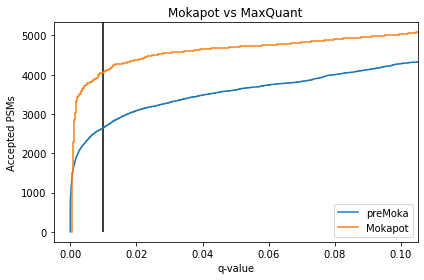

In [10]:
plot_qvalues(mq_cleaned_df["PEP"], label="Pre-mokapot")
plt.title("Mokapot vs MaxQuant")
results.plot_qvalues(label="mokapot")
plt.legend(["preMoka", "Mokapot"])
plt.vlines(x = 0.01, ymin = 0, ymax = 12000)
plt.tight_layout()

plt.show()

In [11]:
print("The number of PSMs found at or above 0.01: ") 
      
print("\t" + "MaxQuant: " + str(len(mq_cleaned_df[mq_cleaned_df['PEP'] <= 0.01])))

print("\t""MaxQuant and MokaPot: " + str(len(results.psms[results.psms['mokapot q-value'] <= 0.01])))

The number of PSMs found at or above 0.01: 
	MaxQuant: 2647
	MaxQuant and MokaPot: 4060


In [12]:
print(len(mq_cleaned_df))
print(len(results.psms))

12243
8458
